In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import pickle
import matplotlib.dates as mdates


import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, moca, gaussian_vel_reconstruction, espra


#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

    

#### Drifter Data

In [3]:
drifter_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/CCE_2023_6h.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
ID_drif =  drifter_dataset['ID'][:]
secs = drifter_dataset['time'][:].data
tim_drif = [datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S') for t in secs]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters[np.hypot(df_drifters.u, df_drifters.v) < 100]
df_drifters = df_drifters.reset_index().drop(columns=['index'])
df_drifters = df_drifters[df_drifters.Time < pd.Timestamp('2024-02-10 00:00:00')]
df_drifters.head()


,ID,Lon,Lat,u,v,Time
0,300534062034380,153.975,-37.651,0.003961,0.004561,2023-10-19 12:00:00
1,300534062034380,154.095,-37.579,0.004713,0.003265,2023-10-19 18:00:00
2,300534062034380,154.206,-37.523,0.004703,0.001505,2023-10-20 00:00:00
3,300534062034380,154.325,-37.520,0.004957,-0.000603,2023-10-20 06:00:00
4,300534062034380,154.448,-37.547,0.004584,-0.001956,2023-10-20 12:00:00


(np.float64(150.15035),
 np.float64(154.91664999999998),
 np.float64(-38.4239),
 np.float64(-36.4021))

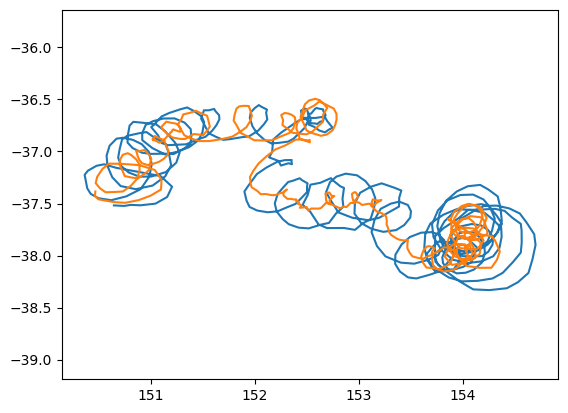

In [4]:
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    plt.plot(df.Lon, df.Lat)
plt.axis('equal')

In [93]:
start = df_drifters.Time.min() + pd.Timedelta(days=1)
end   = df_drifters.Time.max() - pd.Timedelta(days=1)
times = pd.date_range(start, end, freq='D')

Rc_max = 10

results = []
for t in times:
    mask = df_drifters.Time.between(t - pd.Timedelta(days=1),
                                     t + pd.Timedelta(days=1))
    xi, yi = df_drifters.loc[mask, ['Lon', 'Lat']].values.T
    ui, vi = df_drifters.loc[mask, ['u',   'v'  ]].values.T
    xc, yc, w, Q, Rc, psi0 = espra(xi, yi, ui, vi, Rc_max=Rc_max, flag_km=False)
    results.append(dict(xc=xc, yc=yc, w=w, Q=Q, Rc=Rc, psi0=psi0, Time=t))

df_results = pd.DataFrame(results)
df_results

,xc,yc,w,Q,Rc,psi0,Time
0,154.267637,-37.953826,-0.026029,"[[-0.0072666875310506245, 0.000659990926537592...",0.705748,0.498683,2023-10-20 12:00:00
1,154.321904,-37.919899,-0.029592,"[[-0.00860559554466163, 0.0003390979540485265]...",0.072429,0.005930,2023-10-21 12:00:00
2,154.235778,-37.942048,-0.030406,"[[-0.007117291877619892, -0.000389311740622380...",0.075651,0.006520,2023-10-22 12:00:00
3,154.169484,-37.965548,-0.032797,"[[-0.007361517145338164, -0.000984175162243697...",0.061402,0.004529,2023-10-23 12:00:00
4,154.153028,-37.911515,-0.031857,"[[-0.007573243318833828, 0.0003533540088296107...",0.053784,0.003594,2023-10-24 12:00:00
...,...,...,...,...,...,...,...
107,150.676653,-37.187982,-0.035476,"[[-0.008871921026608843, 0.002152433001450708]...",3.405437,11.597255,2024-02-04 12:00:00
108,150.654736,-37.237212,-0.038747,"[[-0.007806389975327838, 0.0025276662953989913...",0.707743,0.501174,2024-02-05 12:00:00
109,150.705005,-37.318210,-0.035389,"[[-0.005028825757365147, -0.001447955260680779...",0.055244,0.003395,2024-02-06 12:00:00
110,150.685157,-37.294499,-0.043674,"[[-0.004910356873446585, -0.002288794605155998...",0.113194,0.013191,2024-02-07 12:00:00


Smooth out Q, Rc and psi0

In [94]:
# def smooth(x, y, num=1000, window=100):
#     from scipy.interpolate import interp1d
#     from scipy.ndimage import uniform_filter1d
#     x = np.asarray(x); y = np.asarray(y)
#     # Step 1: interpolate to uniform y
#     y_uniform = np.linspace(y.min(), y.max(), num)
#     f_interp = interp1d(y, x, kind='linear', fill_value='extrapolate')
#     x_uniform = f_interp(y_uniform)
#     # Step 2: smooth x on the uniform y grid
#     x_smooth_uniform = uniform_filter1d(x_uniform, size=window)
#     # Step 3: interpolate back to original y
#     f_smooth = interp1d(y_uniform, x_smooth_uniform, kind='linear', fill_value='extrapolate')
#     x_smooth = f_smooth(y)

#     return x_smooth

from scipy.interpolate import interp1d

def smooth(x, y, num=1000, window=100):
    """
    Smooth x vs y by:
      1) interpolating onto a uniform y-grid
      2) applying a running nan‑mean of width `window`
      3) interpolating back to the original y

    Any output point whose window contains only NaNs will be NaN.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    # 1) uniform y grid & interpolation
    y_uniform = np.linspace(y.min(), y.max(), num)
    f_interp = interp1d(y, x, kind='linear', fill_value='extrapolate')
    x_uniform = f_interp(y_uniform)

    # 2) running nan-mean on the uniform grid
    def moving_nanmean(a, win):
        """Return an array the same size as a, where each point is the mean of
        the surrounding win points (including itself), ignoring NaNs."""
        valid = ~np.isnan(a)
        # fill NaNs with zero so they don't contribute to sum
        a_fill = np.where(valid, a, 0.0)
        # convolution kernels
        kernel = np.ones(win, dtype=float)
        # sums of valid data
        sums   = np.convolve(a_fill, kernel, mode='same')
        # counts of valid entries
        counts = np.convolve(valid.astype(float), kernel, mode='same')
        # compute mean; outside domain or where counts==0 gives NaN
        with np.errstate(divide='ignore', invalid='ignore'):
            mu = sums / counts
        mu[counts == 0] = np.nan
        return mu

    x_smooth_uniform = moving_nanmean(x_uniform, window)

    # 3) back to original y
    f_smooth = interp1d(y_uniform, x_smooth_uniform,
                        kind='linear', fill_value='extrapolate')
    x_smooth = f_smooth(y)

    return x_smooth


wdw = 10
q11 = smooth(df_results.Q.apply(lambda Q: Q[0, 0]), np.arange(len(df_results)), num=len(df_results), window=wdw)
q12 = smooth(df_results.Q.apply(lambda Q: Q[0, 1]), np.arange(len(df_results)), num=len(df_results), window=wdw)
q22 = smooth(df_results.Q.apply(lambda Q: Q[1, 1]), np.arange(len(df_results)), num=len(df_results), window=wdw)
df_results['sw'] = 2*(q11 + q22)
df_results['sQ'] = [np.array([[q11[i], q12[i]], 
                [q12[i], q22[i]]]) for i in range(len(q11))]

mask = df_results.Rc.values >= Rc_max
Rcs = df_results.Rc.copy()
psi0s = df_results.psi0.copy()
Rcs[mask] = np.nan
psi0s[mask] = np.nan

df_results['sRc'] = smooth(Rcs, np.arange(len(df_results)), num=len(df_results), window=wdw)
df_results['spsi0'] = smooth(psi0s, np.arange(len(df_results)), num=len(df_results), window=wdw)

    

(np.float64(150.15035),
 np.float64(154.91664999999998),
 np.float64(-38.4239),
 np.float64(-36.4021))

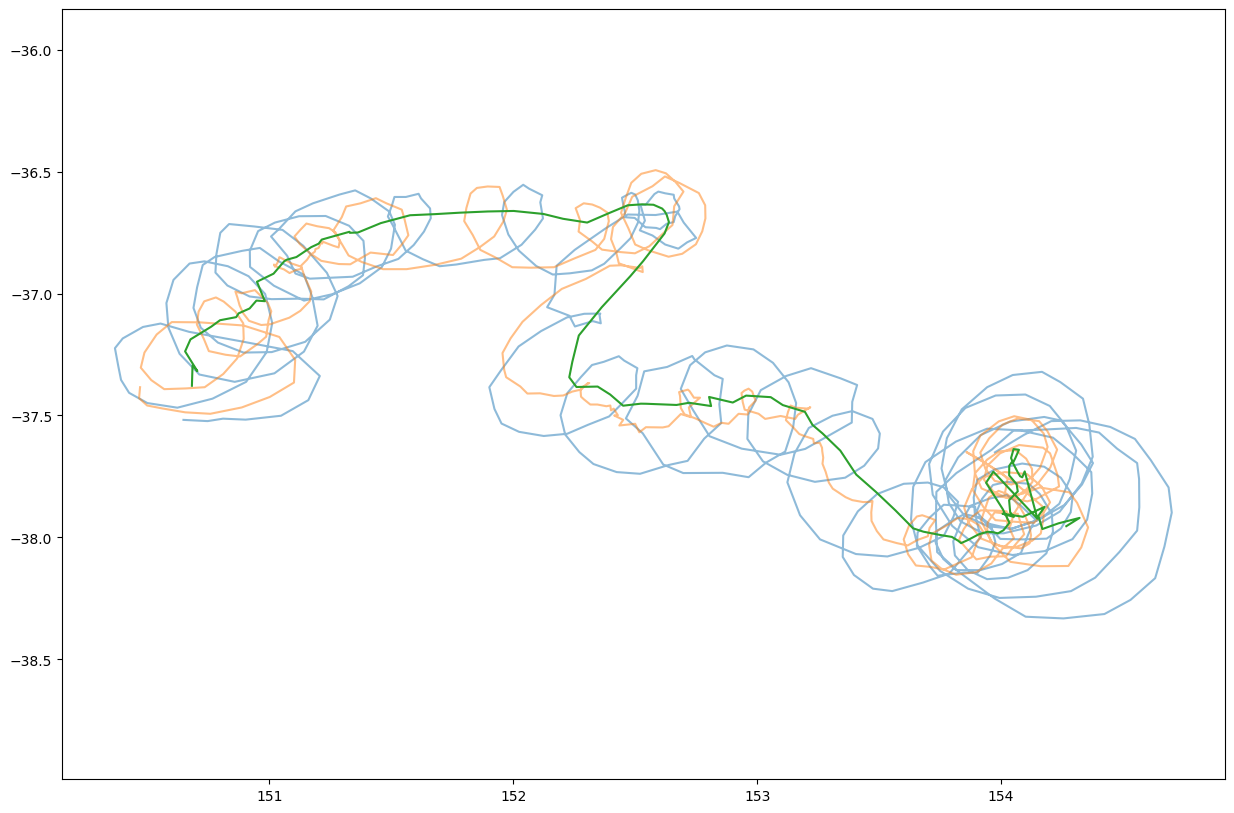

In [95]:
plt.figure(figsize=(15,10))
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    plt.plot(df.Lon, df.Lat, alpha=.5)
    
plt.plot(df_results.xc, df_results.yc)
plt.axis('equal')


(np.float64(148.55662057374067),
 np.float64(156.69169576237996),
 np.float64(-40.463206795089704),
 np.float64(-34.68485635637949))

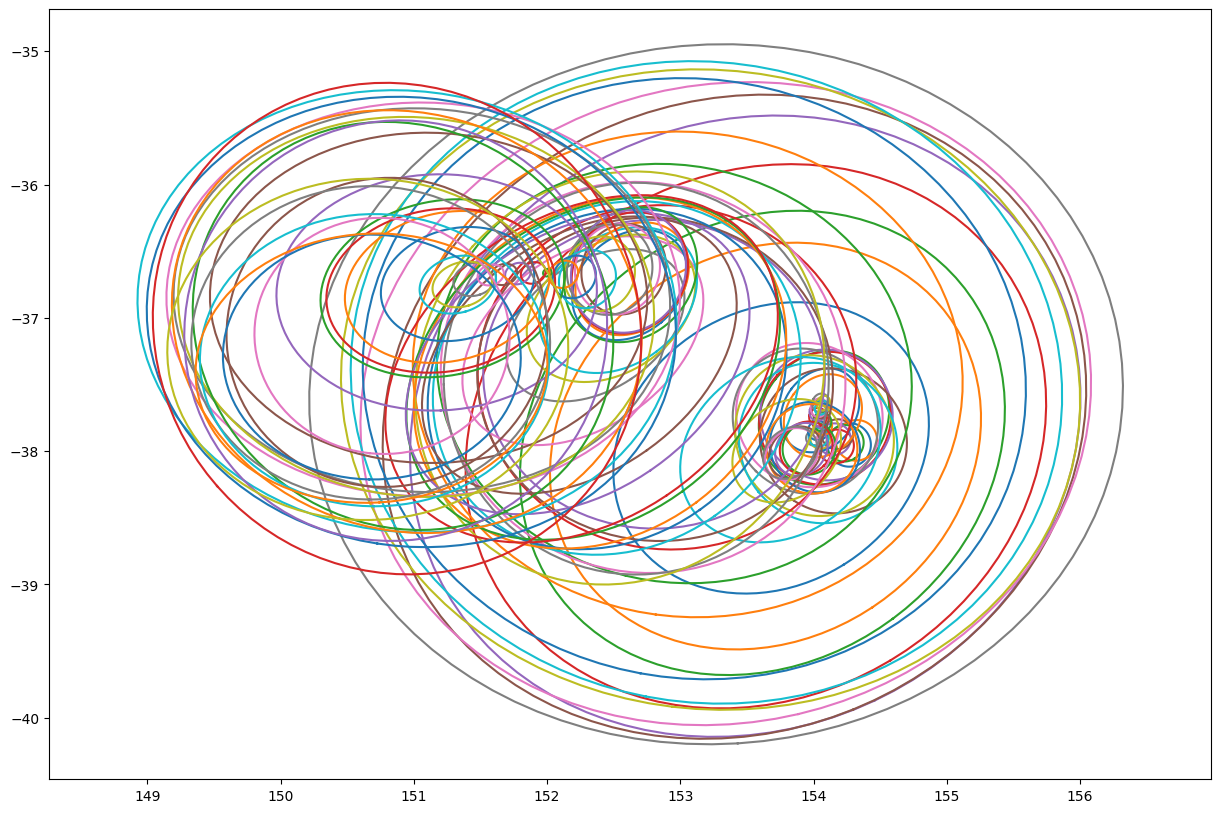

In [96]:
plt.figure(figsize=(15,10))
for (xc, yc, Q, Rc) in zip(df_results.xc, df_results.yc, df_results.sQ, df_results.sRc):
    x_ell, y_ell = plot_ellipse(Q, (xc,yc), scale=Rc)
    plt.plot(x_ell, y_ell)
plt.axis('equal')


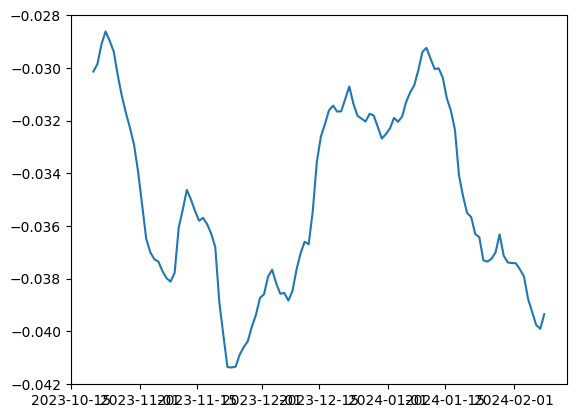

In [97]:
plt.plot(df_results.Time, df_results.sw)

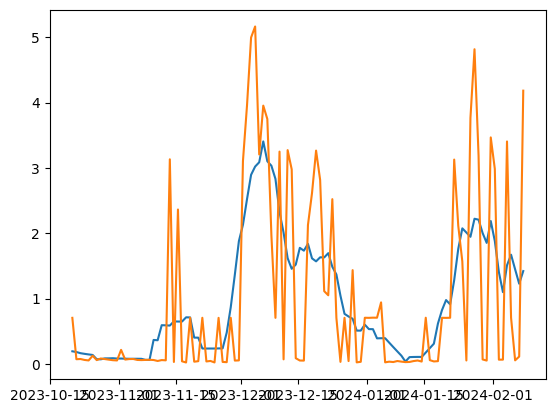

In [117]:
plt.plot(df_results.Time, df_results.sRc)

plt.plot(df_results.Time, df_results.Rc)


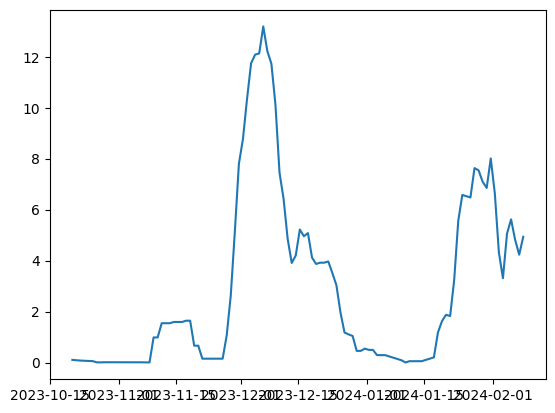

In [99]:
plt.plot(df_results.Time, df_results.spsi0)
# plt.plot(df_results.Time, df_results.psi0)


In [100]:
df_results[df_results.Time.values==pd.Timestamp('2023-11-17 12:00:00')]

,xc,yc,w,Q,Rc,psi0,Time,sw,sQ,sRc,spsi0
28,154.007357,-37.884385,-0.040523,"[[-0.009819601152974769, -0.004545319871428820...",0.022616,0.00071,2023-11-17 12:00:00,-0.035933,"[[-0.009102559709146875, -0.000557581513513968...",0.713649,1.640785


### SWOT

In [101]:
# lon0, lon1 = df_drifters.Lon.min(), df_drifters.Lon.max()
# lat0, lat1 = df_drifters.Lat.min(), df_drifters.Lat.max()

lon0, lon1 = 150, 155.5
lat0, lat1 = -39, -35

tim0, tim1 = df_drifters.Time.min(), df_drifters.Time.max()

print(lon0, lon1, lat0, lat1, tim0, tim1)


150 155.5 -39 -35 2023-10-19 12:00:00 2024-02-09 18:00:00


(np.float64(150.11035195),
 np.float64(155.75660904999998),
 np.float64(-39.1998819),
 np.float64(-34.80025809999999))

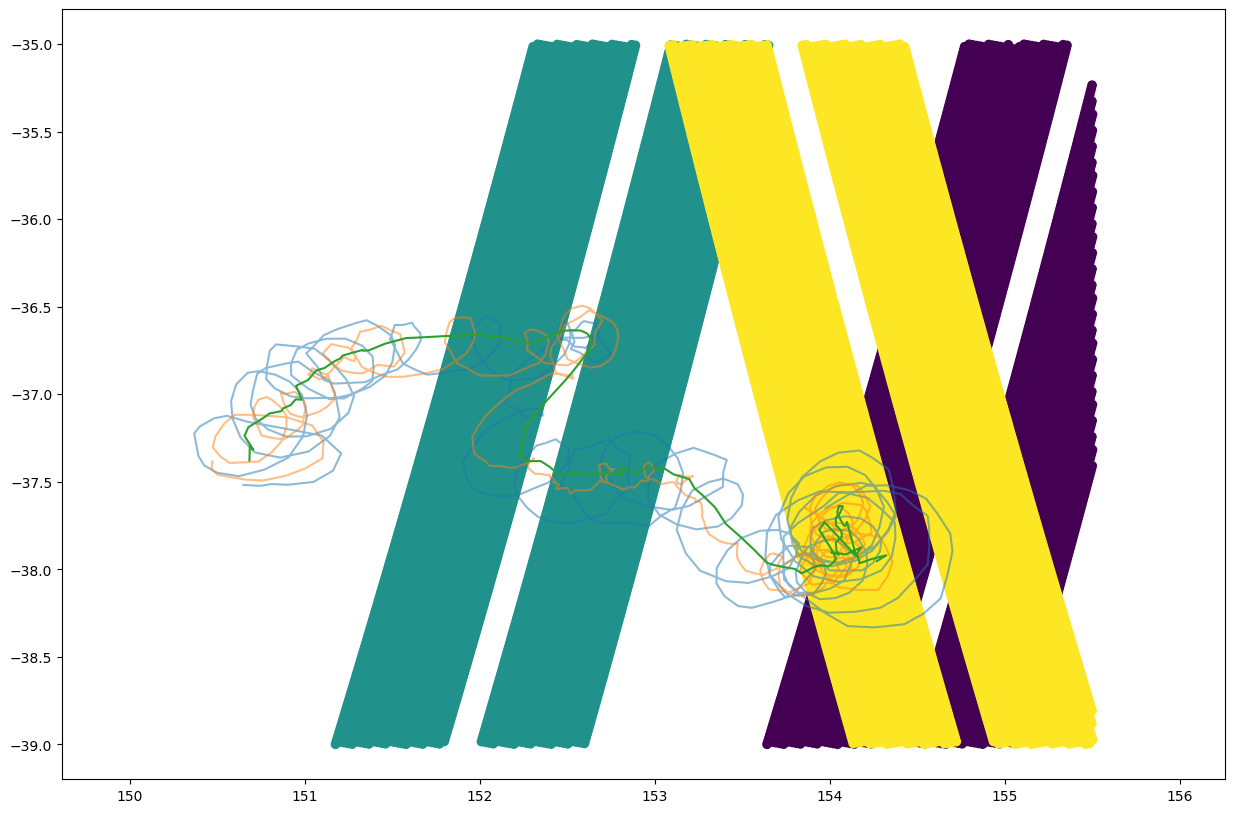

In [102]:
swot_path1 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_211_20231020T043758_20231020T052925_v2.0.1.nc'
swot_dataset1 = nc.Dataset(swot_path1, mode='r')

u_swot1, v_swot1 = swot_dataset1['ugos_filtered'][:].data, swot_dataset1['vgos_filtered'][:].data
lon_swot1, lat_swot1 = swot_dataset1['longitude'][:].data, swot_dataset1['latitude'][:].data
time_swot1 = swot_dataset1['time'][:].data

swot_path2 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_239_20231021T043829_20231021T052956_v2.0.1.nc'
swot_dataset2 = nc.Dataset(swot_path2, mode='r')

u_swot2, v_swot2 = swot_dataset2['ugos_filtered'][:].data, swot_dataset2['vgos_filtered'][:].data
lon_swot2, lat_swot2 = swot_dataset2['longitude'][:].data, swot_dataset2['latitude'][:].data
time_swot2 = swot_dataset2['time'][:].data

swot_path3 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_226_20231020T172941_20231020T182107_v2.0.1.nc'
swot_dataset3 = nc.Dataset(swot_path3, mode='r')

u_swot3, v_swot3 = swot_dataset3['ugos_filtered'][:].data, swot_dataset3['vgos_filtered'][:].data
lon_swot3, lat_swot3 = swot_dataset3['longitude'][:].data, swot_dataset3['latitude'][:].data
time_swot3 = swot_dataset3['time'][:].data

df_time1 = pd.DataFrame({'Time': pd.to_datetime(time_swot1, unit='s', origin='2000-01-01')})
df_time1 = df_time1.loc[df_time1.index.repeat(lon_swot1.shape[1])].reset_index(drop=True)
df_swot1 = pd.concat([
    pd.DataFrame({'ID': [1]*len(df_time1)}),
    df_time1,
    pd.DataFrame({'Lon': lon_swot1.ravel()}),
    pd.DataFrame({'Lat': lat_swot1.ravel()}),
    pd.DataFrame({'u': u_swot1.ravel()}),
    pd.DataFrame({'v': v_swot1.ravel()}),
], axis=1)

df_time2 = pd.DataFrame({'Time': pd.to_datetime(time_swot2, unit='s', origin='2000-01-01')})
df_time2 = df_time2.loc[df_time2.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot2 = pd.concat([
    pd.DataFrame({'ID': [2]*len(df_time2)}),
    df_time2,
    pd.DataFrame({'Lon': lon_swot2.ravel()}),
    pd.DataFrame({'Lat': lat_swot2.ravel()}),
    pd.DataFrame({'u': u_swot2.ravel()}),
    pd.DataFrame({'v': v_swot2.ravel()}),
], axis=1)

df_time3 = pd.DataFrame({'Time': pd.to_datetime(time_swot3, unit='s', origin='2000-01-01')})
df_time3 = df_time3.loc[df_time3.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot3 = pd.concat([
    pd.DataFrame({'ID': [3]*len(df_time3)}),
    df_time3,
    pd.DataFrame({'Lon': lon_swot3.ravel()}),
    pd.DataFrame({'Lat': lat_swot3.ravel()}),
    pd.DataFrame({'u': u_swot3.ravel()}),
    pd.DataFrame({'v': v_swot3.ravel()}),
], axis=1)

df_swot = pd.concat([df_swot1, df_swot2, df_swot3], axis=0)
df_swot = df_swot[np.hypot(df_swot.u, df_swot.v) < 100]  # FILTER!!
df_swot = df_swot.reset_index().drop(columns=['index'])

df = df_swot.copy()
df_swot_CE = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
                (df.Lat >= lat0) & (df.Lat <= lat1) &
                (df.Time >= tim0) & (df.Time <= tim1)]

df_swot_CE = df_swot_CE.reset_index().drop(columns=['index'])

plt.figure(figsize=(15,10))
plt.scatter(df_swot_CE.Lon, df_swot_CE.Lat, c=df_swot_CE.ID)
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    plt.plot(df.Lon, df.Lat, alpha=.5)
    
plt.plot(df_results.xc, df_results.yc)
plt.axis('equal')


In [103]:
df_drifters

,ID,Lon,Lat,u,v,Time
0,300534062034380,153.975,-37.651,0.003961,0.004561,2023-10-19 12:00:00
1,300534062034380,154.095,-37.579,0.004713,0.003265,2023-10-19 18:00:00
2,300534062034380,154.206,-37.523,0.004703,0.001505,2023-10-20 00:00:00
3,300534062034380,154.325,-37.520,0.004957,-0.000603,2023-10-20 06:00:00
4,300534062034380,154.448,-37.547,0.004584,-0.001956,2023-10-20 12:00:00
...,...,...,...,...,...,...
1642,300534062784620,150.655,-37.487,-0.004042,0.000568,2024-02-08 18:00:00
1643,300534062784620,150.561,-37.471,-0.003180,0.000716,2024-02-09 00:00:00
1644,300534062784620,150.499,-37.459,-0.001929,0.001081,2024-02-09 06:00:00
1645,300534062784620,150.466,-37.429,-0.000604,0.001938,2024-02-09 12:00:00


(-39.0, -35.0)

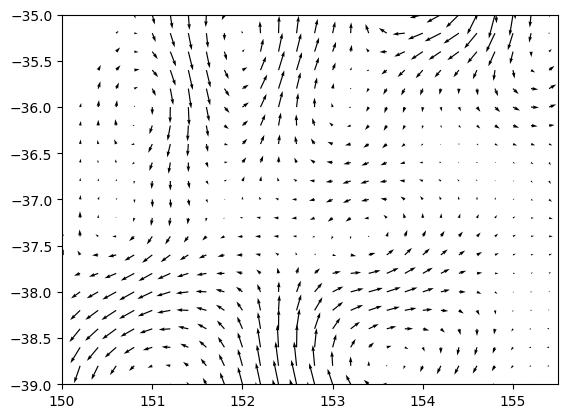

In [104]:
plt.quiver(lon_ssh, lat_ssh, ut, vt, scale=20)
plt.xlim(150, 155.5)
plt.ylim(-39, -35)

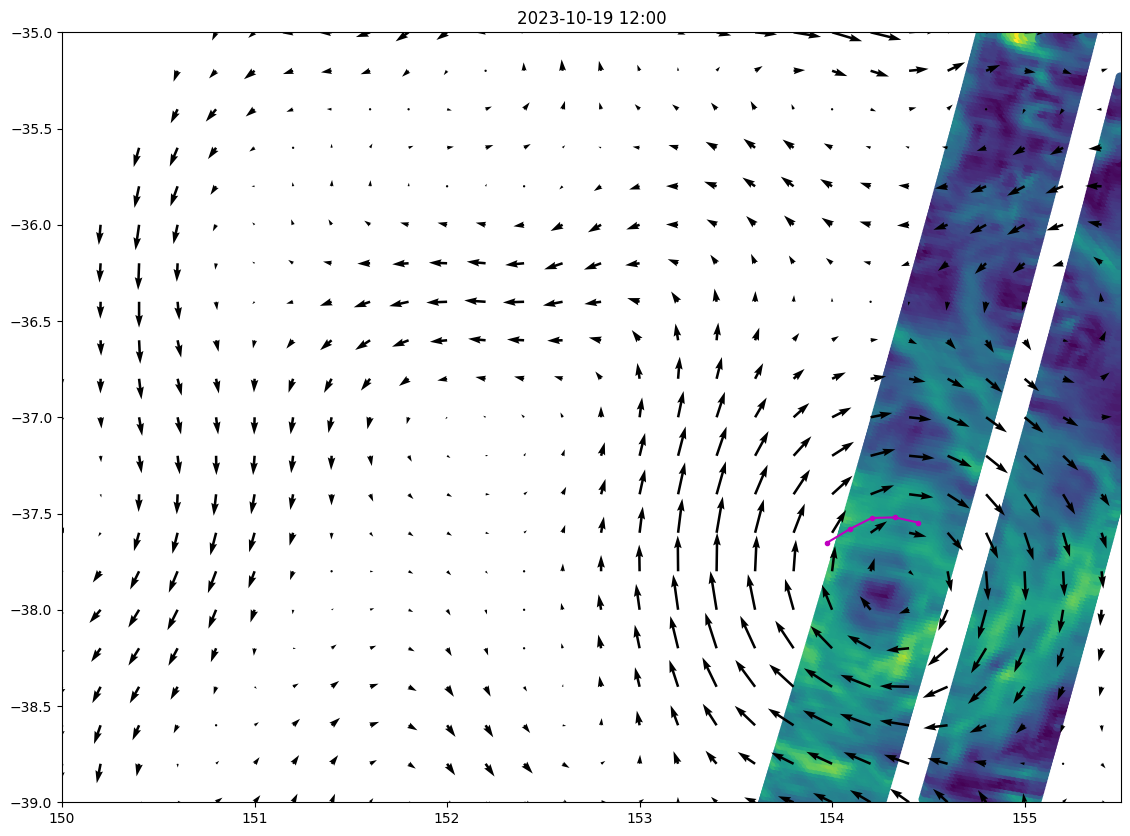

In [20]:
import matplotlib.animation as animation

# ensure Time columns are datetime
df_swot_CE['Time']   = pd.to_datetime(df_swot_CE['Time'])
df_drifters['Time']  = pd.to_datetime(df_drifters['Time'])
df_results['Time']   = pd.to_datetime(df_results['Time'])

# build the sequence of frame‐times (here stepping every 12 h)
min_t = min(df_swot_CE.Time.min(), df_drifters.Time.min(), df_results.Time.min())
max_t = max(df_swot_CE.Time.max(), df_drifters.Time.max(), df_results.Time.max())
frame_times = pd.date_range(min_t, max_t, freq='D')

fig, ax = plt.subplots(figsize=(15,10))

def update(t):
    ax.clear()

    w0 = t - pd.Timedelta(days=1)
    w1 = t + pd.Timedelta(days=1)
    sub_ce = df_swot_CE[(df_swot_CE.Time>=w0)&(df_swot_CE.Time<=w1)]
    ax.scatter(sub_ce.Lon, sub_ce.Lat, c=np.hypot(sub_ce.u, sub_ce.v))

    closest = max([tt for tt in tim_ssh if tt <= t], default=None)
    ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
    ax.quiver(lon_ssh, lat_ssh, ut, vt, scale=20)

    ax.plot(df_results.xc, df_results.yc, linewidth=.5, color='r') # Center Trace
    
    for d in df_drifters.ID.unique():
        dd = df_drifters[(df_drifters.ID==d)&(df_drifters.Time>=w0)&(df_drifters.Time<=w1)]
        ax.plot(dd.Lon, dd.Lat, alpha=1, marker='.', linewidth=1.5, color='m')
    if t in df_results.Time.values:
        sub_r = df_results[df_results.Time.values==t].iloc[0]
        ax.scatter(sub_r.xc, sub_r.yc, marker='x', color='r', s=100)
        x_ell, y_ell = plot_ellipse(sub_r.Q, (sub_r.xc, sub_r.yc), scale=sub_r.sRc * 5)
        ax.plot(x_ell, y_ell, color='r')
    ax.set_aspect('equal')
    ax.set_title(t.strftime('%Y-%m-%d %H:%M'))
    ax.set_xlim(150, 155.5)
    ax.set_ylim(-39, -35)

ani = animation.FuncAnimation(fig, update, frames=frame_times, blit=False, repeat=False)

# to display inline (e.g. in Jupyter)
# plt.show()

# — or to save as MP4 (requires ffmpeg):
# ani.save('timelapse.mp4', writer='ffmpeg', fps=4)

# — or to save as GIF (requires imagemagick):
ani.save('timelapse.gif', writer='imagemagick', fps=4)


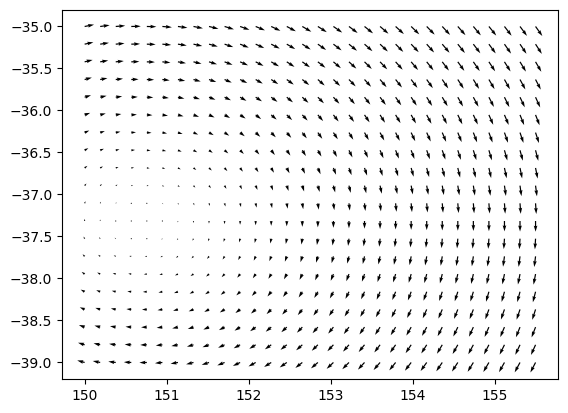

In [106]:
x, y = np.linspace(lon0, lon1, 30), np.linspace(lat0, lat1, 20)
X, Y = np.meshgrid(x, y)

U, V = np.zeros((X.shape[0], X.shape[1], len(df_results))), np.zeros((X.shape[0], X.shape[1], len(df_results)))
for k in range(len(df_results)):
    data = df_results.iloc[k]
    u, v, *_ = gaussian_vel_reconstruction(data.xc, data.yc, data.sQ[0,0], data.sQ[1,0], data.sQ[1,1], data.sRc, data.spsi0, X=X, Y=Y)
    U[:,:,k], V[:,:,k] = u, v

k = 110
plt.quiver(X, Y, U[:,:,k], V[:,:,k], scale=20)



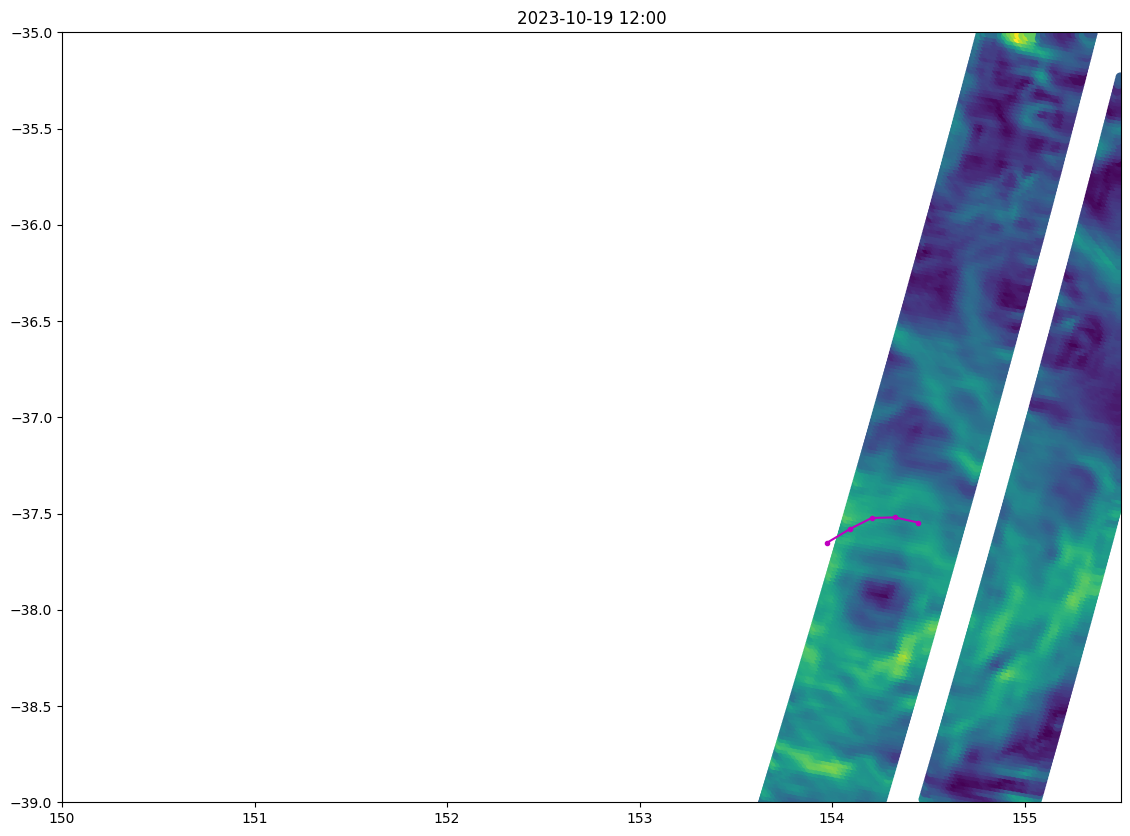

In [109]:
import matplotlib.animation as animation

# ensure Time columns are datetime
df_swot_CE['Time']   = pd.to_datetime(df_swot_CE['Time'])
df_drifters['Time']  = pd.to_datetime(df_drifters['Time'])
df_results['Time']   = pd.to_datetime(df_results['Time'])

# build the sequence of frame‐times (here stepping every 12 h)
min_t = min(df_swot_CE.Time.min(), df_drifters.Time.min(), df_results.Time.min())
max_t = max(df_swot_CE.Time.max(), df_drifters.Time.max(), df_results.Time.max())
frame_times = pd.date_range(min_t, max_t, freq='D')

fig, ax = plt.subplots(figsize=(15,10))

def update(t):
    ax.clear()

    w0 = t - pd.Timedelta(days=1)
    w1 = t + pd.Timedelta(days=1)
    sub_ce = df_swot_CE[(df_swot_CE.Time>=w0)&(df_swot_CE.Time<=w1)]
    ax.scatter(sub_ce.Lon, sub_ce.Lat, c=np.hypot(sub_ce.u, sub_ce.v))

    if t in df_results.Time.values:
        idx = np.where(t==df_results.Time.values)[0][0]
        u, v = U[:,:,idx], V[:,:,idx]
        ax.quiver(X, Y, u, v, scale=20)

    for d in df_drifters.ID.unique():
        dd = df_drifters[(df_drifters.ID==d)&(df_drifters.Time>=w0)&(df_drifters.Time<=w1)]
        ax.plot(dd.Lon, dd.Lat, alpha=1, marker='.', linewidth=1.5, color='m')

    if t in df_results.Time.values:
        sub_r = df_results[df_results.Time.values==t].iloc[0]
        ax.scatter(sub_r.xc, sub_r.yc, marker='x', color='r', s=100)
    
    
    ax.set_aspect('equal')
    ax.set_title(t.strftime('%Y-%m-%d %H:%M'))
    ax.set_xlim(150, 155.5)
    ax.set_ylim(-39, -35)

ani = animation.FuncAnimation(fig, update, frames=frame_times, blit=False, repeat=False)

# to display inline (e.g. in Jupyter)
# plt.show()

# — or to save as MP4 (requires ffmpeg):
# ani.save('timelapse.mp4', writer='ffmpeg', fps=4)

# — or to save as GIF (requires imagemagick):
ani.save('timelapse_reco.gif', writer='imagemagick', fps=4)
